In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import f1_score, normalized_mutual_info_score, rand_score
import warnings
warnings.filterwarnings("ignore")

## <font color="#bd33a4"> KMeans From Scractch

In [128]:
class KMeans:
    def __init__(self, n_clusters, max_iter=300, random_state=None, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol
        self.centroids = None

    def _initialize_centroids(self, X):
        if self.random_state:
            np.random.seed(self.random_state)

        centroids = [X[np.random.choice(range(X.shape[0]))]]
        for _ in range(1, self.n_clusters):
            distances = np.min(cdist(X, centroids, 'euclidean'), axis=1)
            prob = distances / np.sum(distances)
            cumulative_prob = np.cumsum(prob)
            r = np.random.rand()
            i = np.searchsorted(cumulative_prob, r)
            centroids.append(X[i])
        return np.array(centroids)

    def fit(self, X):
        self.centroids = self._initialize_centroids(X)

        for _ in range(self.max_iter):
            distances = cdist(X, self.centroids, 'euclidean')
            labels = np.argmin(distances, axis=1)

            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])
            diff = np.linalg.norm(new_centroids - self.centroids)
            if diff < self.tol:
                break

            self.centroids = new_centroids

        return labels

    def predict(self, X):
        distances = cdist(X, self.centroids, 'euclidean')
        return np.argmin(distances, axis=1)

## <font color="#bd33a4"> DBSCAN From Scractch

In [129]:
class DBSCAN:
    # DBSCAN (Density-Based Spatial Clustering of Applications with Noise) implementation
    # Used to classify points as core, border, or noise in a given dataset




    def __init__(self, data, eps: float, min_samples: int):
        """
        Initialize DBSCAN object with the given parameters.

        Parameters:
        - data: The input dataset, where each row represents a data point with coordinates.
        - eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
        - min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.

        Initializes internal variables and sets up the initial state of the dataset.
        """
        self.eps = eps
        self.min_samples = min_samples
        self.data = data
        self.dataSet1 = pd.DataFrame(self.data, columns=['x', 'y'])
        self.dataSet1["state"] = -1  # -1 represents unclassified
        self.dataSet1["Clusters"] = -1  # -1 represents unassigned cluster
        self.core = []  # List to store core points
        self.border = []  # List to store border points
        self.noise = []  # List to store noise points
        self.cluster = []


    def distance_matrix(self):
        """
        Create a distance matrix for the given dataset.

        Returns:
        - distance_of_matrix: The matrix where element [i, j] represents the distance between data points i and j.
        """
        n = len(self.data)
        distance_of_matrix = np.zeros((n, n))

        # Calculate Euclidean distance between each pair of points
        for i in range(n):
            for j in range(n):
                distance_of_matrix[i, j] = np.linalg.norm(self.data[i] - self.data[j])

        return distance_of_matrix



    def neighbor_points(self):
        """
        Find all neighbor points for every point based on the epsilon value and minimum points in the circle .

        Returns:
        - Neighboring_points: list contains all neighbors of each point.
        """
        distances=self.distance_matrix()
        Neighboring_points=[]

        for i in range(len(distances)):
          for j in range(len(distances[0])):

            if(distances[i][j]<=self.eps):
                 Neighboring_points.append([i,j])

        return Neighboring_points


    def is_in_cluster(self,cluster,corPoint):
         """
         To find the index of the cluster that is the core neighbor of the point.

         Returns:
         -If the core neighbor is part of a cluster, return the index of the cluster.
         -If not, return -1 to indicate that no cluster was found.
         """
         for i in range(len(cluster)):
          for j in range(len(cluster[i])):
            if(cluster[i][j]==corPoint):
                return i

         return -1


    def density_reachable(self,cluster,C1,C2):
         """
         Merge clusters that have a density reachable connection between them.

         Returns:
         -After merging two clusters that are density reachable, return the new clusters .
         """

         for i in range(len(cluster[C2])):

            cluster[C1].append(cluster[C2][i])

         for i in range(len(cluster[C2])):
            cluster[C2].pop()

         return cluster


    def predict(self,stateData,core,border):
           """
           Predict the clusters of the dataset based on the state of each point and its neighbors.

           Returns:
           -the final clusters of the dataset.
           """
           self.core=core
           self.border=border
           StateDate=stateData
           neighboring_points=self.neighbor_points()

           #Creating clusters for core points.
           for i in range(len(self.dataSet1)):

               #If there are no clusters created yet, then make the first cluster.
               if (StateDate[i]=='core' and len(self.cluster)==0):

                  self.dataSet1["Clusters"][i]=0
                  self.cluster.append([i])

               #if there is a clusters search if there's a neighbor point that has been assigned to a cluster.
               elif (StateDate[i]=='core' and len(self.cluster)!=0):


                   for j in range(len(neighboring_points)):

                       if(neighboring_points[j][0]==i):

                          for z in range(len(self.core)):

                             if(neighboring_points[j][1]==self.core[z]):

                                find=self.is_in_cluster(self.cluster,self.core[z])

                                #If the neighboring point has already been assigned to a cluster, assign the current point to the same cluster.
                                if(find!=-1):
                                  self.dataSet1["Clusters"][i]=find
                                  self.cluster[find].append(i)
                                  break
                   #If there are no neighboring points assigned to a cluster, a new cluster will be created.
                   if(self.dataSet1["Clusters"][i]==-1):
                      self.cluster.append([i])
                      self.dataSet1["Clusters"][i]=(len(self.cluster))+1

           #After assigning all the core points, assign all the border points to their respective cores.
           for i in range(len(self.dataSet1)):

                   if (StateDate[i]=='border'):

                      for j in range(i,len(neighboring_points)):

                          if(neighboring_points[j][0]==i):

                             for z in range(len(self.core)):

                                 if(neighboring_points[j][1]==self.core[z]):

                                    find=self.is_in_cluster(self.cluster,self.core[z])
                                    if(find!=-1):
                                          self.dataSet1["Clusters"][i]=find
                                          self.cluster[find].append(i)
                                          break

           #All clusters that are density-reachable with each other will be merged into one cluster.
           for i in range(len(self.cluster)):
               for j in range(len(self.cluster)):
                  if(i!=j):
                    for itemC1 in range(len(self.cluster[i])):
                       for itemC2 in range(len(self.cluster[j])):
                          if(self.cluster[i][itemC1]==self.cluster[j][itemC2]):

                            self.cluster=self.density_reachable(self.cluster,i,j)
                            break

           #to remove the empty indexes from the list because they have been transferred into another index.
           while([]in self.cluster):
              self.cluster.remove([])
           #Update the cluster of each point in dataSet1["Clusters"].
           for i in range(len(self.cluster)):
               for j in range(len(self.cluster[i])):
                    if(self.dataSet1["Clusters"][self.cluster[i][j]]!= i):
                        self.dataSet1["Clusters"][self.cluster[i][j]]= i


           return self.dataSet1["Clusters"]



    def fit(self):
       """
       Determine the state of each point by analyzing the list of neighboring points.

       Returns:
       -The list of the points states and two array of the core and border points.
       """
       The_point=0
       Point_count=0
       neighboring_points=self.neighbor_points()

       #The first step is to determine the state of each core point based on the number of its neighbors.
       for i in range(len(neighboring_points)):

         if neighboring_points[i][0]==The_point :

            Point_count+=1

         elif (neighboring_points[i][0]!=The_point and Point_count>=self.min_samples):

            self.core.append(The_point)
            self.dataSet1["state"][The_point]='core'
            The_point+=1
            Point_count=1

         elif (neighboring_points[i][0]!=The_point and Point_count<=self.min_samples):
            The_point+=1
            Point_count=1


       #When a point has a neighbor core and its value is still -1, it is considered a border point.
       for i in range(len(self.dataSet1)):

          if(self.dataSet1["state"][i]==-1):

             for j in range(i,len(neighboring_points)):

                 for z in range(len(self.core)):

                     if (neighboring_points[j][0]==i and neighboring_points[j][1]==self.core[z]):
                         self.border.append(i)
                         self.dataSet1["state"][i]='border'
                         break

       #Every state point that has a value of -1 is considered as noise.
       for i,n in enumerate(self.dataSet1["state"]):

           if n==-1:
              self.dataSet1["state"][i]='nois'


       return self.dataSet1["state"],self.core,self.border

### <font color="#bd33a4"> Calculate Randome State:
    1- Ruba Alsualmi: 2110618 ---> 2+1+1+0+6+1+8= 19
    2- Arjwan Alharbi: 2110826 ---> 2+1+1+0+8+2+6= 20
    3- Ramah Alharbi: 2110173 ---> 2+1+1+0+1+7+3= 15
    4- Fay Redha : 2111992 ---> 2+1+1+9+9+2= 24
    5- Riof Alzahrani: 2111606 ---> 2+1+1+1+6+0+6= 17
    
    19 + 20 + 15 + 24 + 17 = 95

In [130]:
n_samples = 300
random_state = 95

### <font color="#bd33a4"> Dataset1: blobs dataset

In [131]:
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)

### <font color="#bd33a4"> Before Apply K-Means and DBSCAN on Dataset1

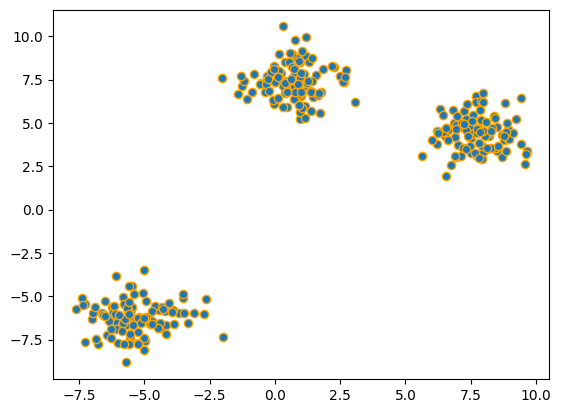

In [132]:
plt.scatter(X[:, 0], X[:, 1],edgecolor='orange')

### <font color="#bd33a4"> After Apply K-Means on Dataset1

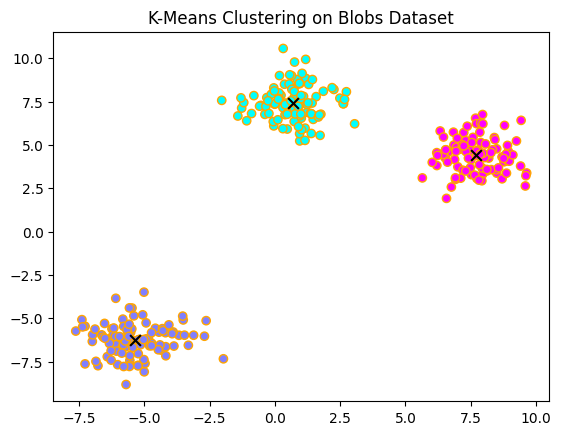

In [133]:
kmeans = KMeans(n_clusters=3, random_state=random_state)
labels = kmeans.fit(X)

# Plot
plt.scatter(X[:, 0], X[:, 1], c=labels, edgecolor='orange',cmap = "cool" )
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1],s = 60,  c='black', marker='x')
plt.title("K-Means Clustering on Blobs Dataset")
plt.show()

In [134]:
f1_blob = f1_score(y, labels, average='weighted')
nmi_blob = normalized_mutual_info_score(y, labels)
rand_index_blob = rand_score(y, labels)


print("**** Measures values for Dataset1 on Kmeans ****\n")
print("F-measure: {:.5f}".format(f1_blob))
print("Normalized Mutual Information (NMI): {:.5f}".format(nmi_blob))
print("Rand Index: {:.5f}".format(rand_index_blob))

**** Measures values for Dataset1 on Kmeans ****

F-measure: 0.00000
Normalized Mutual Information (NMI): 1.00000
Rand Index: 1.00000


### <font color="#bd33a4"> After Apply DBSCAN on Dataset1

In [135]:
DB1=DBSCAN(X,1,4)
Data_State1,corePoint1,borderPoint1=DB1.fit()
DBLabel1=DB1.predict(Data_State1,corePoint1,borderPoint1)

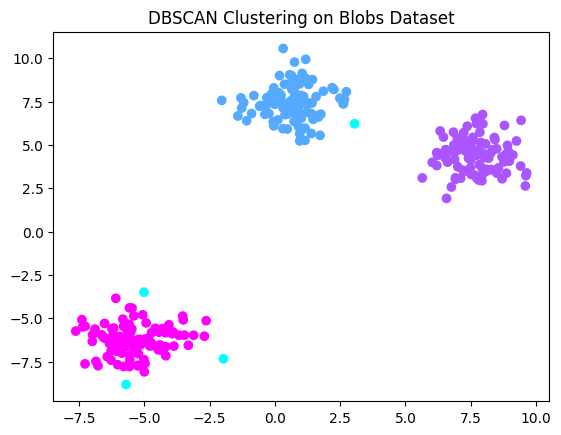

In [136]:
plt.scatter(X[:,0], X[:,1], c=DBLabel1, cmap='cool')
plt.title('DBSCAN Clustering on Blobs Dataset')
plt.show()

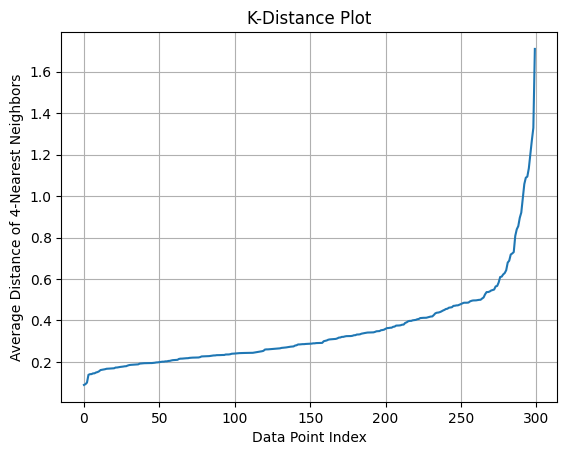

In [137]:
# Calculate the k-distance for each data point
k = 4  # Set the value of k for the k-distance plot
neigh = NearestNeighbors(n_neighbors=k+1)
neigh.fit(X)
distances, indices = neigh.kneighbors(X)
avg_distances = np.mean(distances[:, 1:], axis=1)
sorted_avg_distances = np.sort(avg_distances, axis=0)

plt.plot(np.arange(len(X)), sorted_avg_distances)
plt.xlabel("Data Point Index")
plt.ylabel(f"Average Distance of {k}-Nearest Neighbors")
plt.title("K-Distance Plot")
plt.grid(True)
plt.show()

In [138]:
#Implementing the DBSCAN model with dataset 1 after determining the best epsilon value
DB1=DBSCAN(X,0.8,4)
Data_State1,corePoint1,borderPoint1=DB1.fit()
DBLabel1=DB1.predict(Data_State1,corePoint1,borderPoint1)

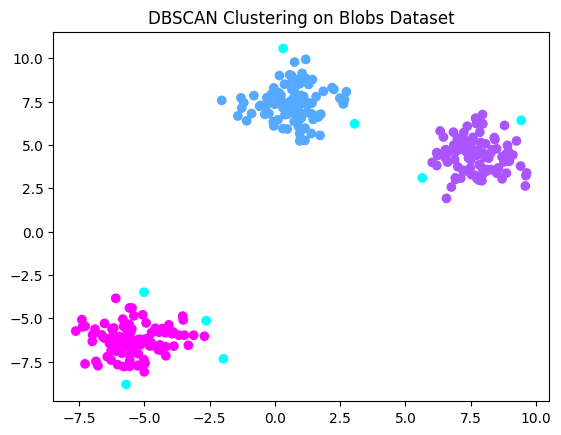

In [139]:
#Visualize the clusters after determining the best epsilon value
plt.scatter(X[:,0], X[:,1], c=DBLabel1, cmap='cool')
plt.title('DBSCAN Clustering on Blobs Dataset')
plt.show()

In [140]:
f_measure = f1_score(y, DBLabel1, average='weighted')
nmi = normalized_mutual_info_score(y, DBLabel1)
rand_index = rand_score(y, DBLabel1)

print("**** Measures values for Dataset1 on DBSCAN ****\n")
print("F-measure: {:.5f}".format(f_measure))
print("Normalized Mutual Information (NMI): {:.5f}".format(nmi))
print("Rand Index: {:.5f}".format(rand_index))

**** Measures values for Dataset1 on DBSCAN ****

F-measure: 0.32997
Normalized Mutual Information (NMI): 0.93493
Rand Index: 0.98225


 ### <font color="#bd33a4">  Summarize the measures values on Dataset1

In [141]:
data = {
    "Dataset": ["Blobs", "Blobs"],
    "Algorithm":["Kmean","DBSCAN"],
    "F1 Score": [f1_blob,f_measure],
    "NMI": [nmi_blob,nmi],
    "Rand Index": [rand_index_blob,rand_index]
}

df_metrics = pd.DataFrame(data)
df_metrics

,Dataset,Algorithm,F1 Score,NMI,Rand Index
0,Blobs,Kmean,0.000000,1.000000,1.000000
1,Blobs,DBSCAN,0.329966,0.934929,0.982252


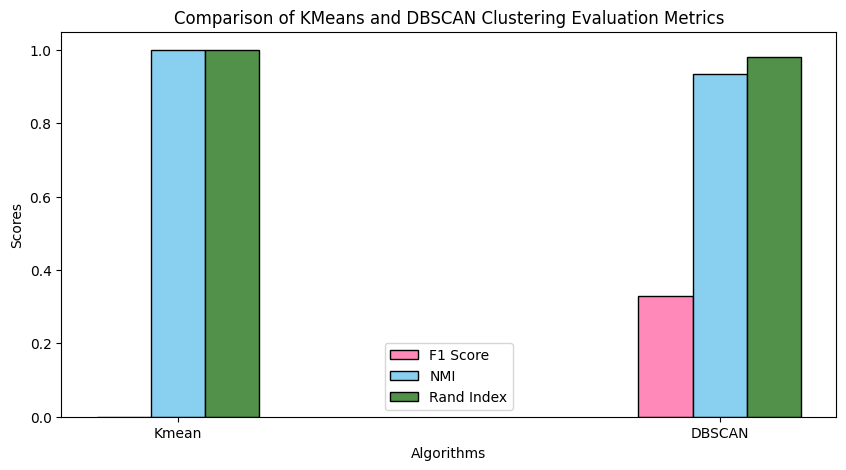

In [142]:
plt.figure(figsize=(10, 5))

metrics = df_metrics['Algorithm']
f1score = df_metrics["F1 Score"]
randscore = df_metrics["NMI"]
normalized_mutual = df_metrics["Rand Index"]

bar_width = 0.1
index = np.arange(len(metrics))

plt.bar(index - bar_width, f1score, bar_width, label='F1 Score', color="#FF8ABA", edgecolor='black')
plt.bar(index, randscore, bar_width, label='NMI', color="#89CFF0", edgecolor='black')
plt.bar(index + bar_width, normalized_mutual, bar_width, label='Rand Index', color="#52914A", edgecolor='black')

plt.xlabel("Algorithms")
plt.ylabel("Scores")
plt.title("Comparison of KMeans and DBSCAN Clustering Evaluation Metrics")
plt.xticks(index, metrics)
plt.legend()
plt.show()

### <font color="#bd33a4"> Dataset2: Anisotropicly distributed dataset

In [143]:
X_aniso, Y_aniso = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X_aniso, transformation)

### <font color="#bd33a4"> Before Apply K-Means and DBSCAN on Dataset2

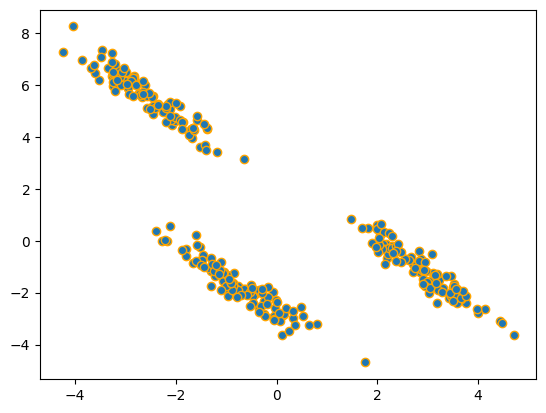

In [144]:
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], edgecolor='orange')

### <font color="#bd33a4"> After Apply K-Means on Dataset2

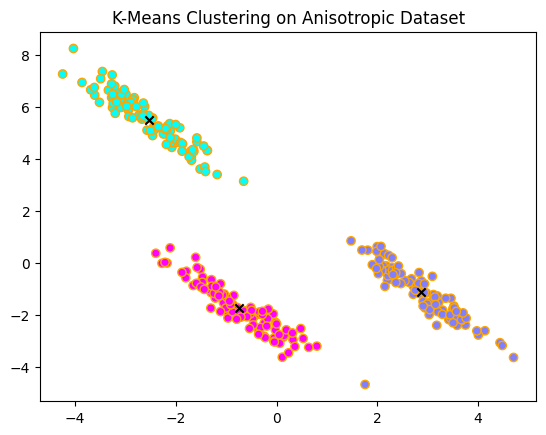

In [145]:
kmeans_aniso = KMeans(n_clusters=3, random_state=random_state)
labels_aniso = kmeans_aniso.fit(X_aniso)

# Plot
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=labels_aniso, edgecolor='orange',cmap = "cool" )
plt.scatter(kmeans_aniso.centroids[:, 0], kmeans_aniso.centroids[:, 1], c='black', marker='x')
plt.title("K-Means Clustering on Anisotropic Dataset")
plt.show()

In [146]:
f1_aniso = f1_score(Y_aniso, labels_aniso, average='weighted')
nmi_aniso = normalized_mutual_info_score(Y_aniso, labels_aniso)
rand_index_aniso = rand_score(Y_aniso, labels_aniso)


print("**** Measures values for Dataset2 on Kmeans ****\n")
print("F-measure: {:.5f}".format(f1_aniso))
print("Normalized Mutual Information (NMI): {:.5f}".format(nmi_aniso))
print("Rand Index: {:.5f}".format(rand_index_aniso))

**** Measures values for Dataset2 on Kmeans ****

F-measure: 0.33167
Normalized Mutual Information (NMI): 0.98299
Rand Index: 0.99556


### <font color="#bd33a4"> After Apply DBSCAN on Dataset2

In [147]:
DB3=DBSCAN(X_aniso,1,3)
Data_State3,corePoint3,borderPoint3=DB3.fit()
DBLabel3=DB3.predict(Data_State3,corePoint3,borderPoint3)

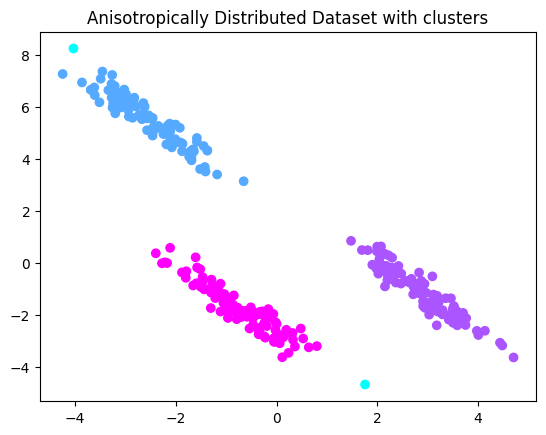

In [148]:
plt.scatter(X_aniso[:,0], X_aniso[:,1], c=DBLabel3, cmap='cool')
plt.title('Anisotropically Distributed Dataset with clusters')
plt.show()

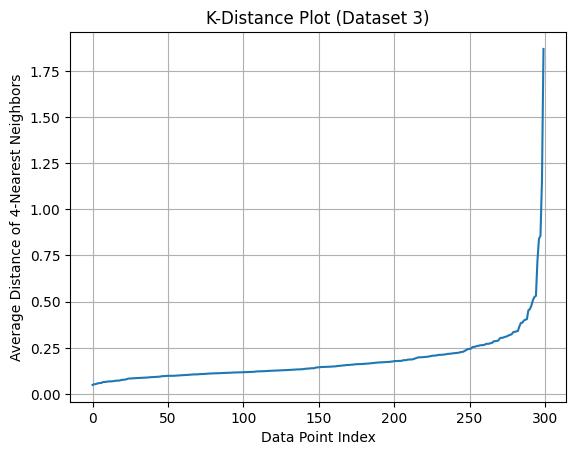

In [149]:
# Calculate k-distance graph
k = 4  # Set the value of k for the k-distance plot
neigh = NearestNeighbors(n_neighbors=k+1)
neigh.fit(X_aniso)
distances, _ = neigh.kneighbors(X_aniso)
avg_distances = np.mean(distances[:, 1:], axis=1)
sorted_avg_distances = np.sort(avg_distances, axis=0)

# Plot the k-distance graph
plt.plot(np.arange(len(X_aniso)), sorted_avg_distances)
plt.xlabel("Data Point Index")
plt.ylabel(f"Average Distance of {k}-Nearest Neighbors")
plt.title("K-Distance Plot (Dataset 3)")
plt.grid(True)
plt.show()

In [150]:
DB3=DBSCAN(X_aniso,0.5,3)
Data_State3,corePoint3,borderPoint3=DB3.fit()
DBLabel3=DB3.predict(Data_State3,corePoint3,borderPoint3)

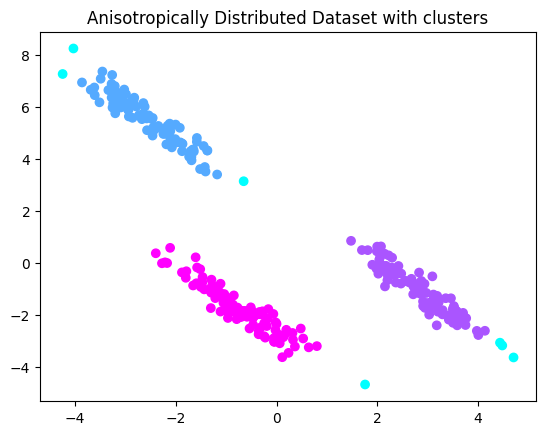

In [151]:
plt.scatter(X_aniso[:,0], X_aniso[:,1], c=DBLabel3, cmap='cool')
plt.title('Anisotropically Distributed Dataset with clusters')
plt.show()

In [152]:
f_measure2 = f1_score(Y_aniso, DBLabel3, average='weighted')
nmi2 = normalized_mutual_info_score(Y_aniso, DBLabel3)
rand_index2 = rand_score(Y_aniso, DBLabel3)

print("**** Measures values for Dataset2 on DBSCAN ****\n")
print("F-measure: {:.5f}".format(f_measure2))
print("Normalized Mutual Information (NMI): {:.5f}".format(nmi2))
print("Rand Index: {:.5f}".format(rand_index2))

**** Measures values for Dataset2 on DBSCAN ****

F-measure: 0.32826
Normalized Mutual Information (NMI): 0.94220
Rand Index: 0.98448


 ### <font color="#bd33a4">  Summarize the measures values on Dataset2

In [153]:
data = {
    "Dataset": ["Anisotropic", "Anisotropic"],
    "Algorithm":["Kmean","DBSCAN"],
    "F1 Score": [f1_aniso, f_measure2],
    "NMI": [nmi_aniso,nmi2],
    "Rand Index": [rand_index_aniso,rand_index2]
}

df_metrics = pd.DataFrame(data)
df_metrics

,Dataset,Algorithm,F1 Score,NMI,Rand Index
0,Anisotropic,Kmean,0.331675,0.982993,0.995563
1,Anisotropic,DBSCAN,0.328257,0.942195,0.984482


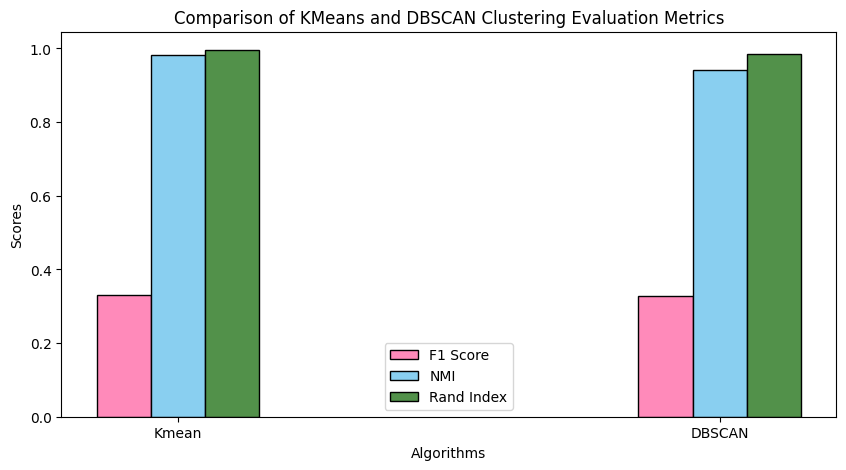

In [154]:
plt.figure(figsize=(10, 5))

metrics = df_metrics['Algorithm']
f1score = df_metrics["F1 Score"]
randscore = df_metrics["NMI"]
normalized_mutual = df_metrics["Rand Index"]

bar_width = 0.1
index = np.arange(len(metrics))

plt.bar(index - bar_width, f1score, bar_width, label='F1 Score', color="#FF8ABA", edgecolor='black')
plt.bar(index, randscore, bar_width, label='NMI', color="#89CFF0", edgecolor='black')
plt.bar(index + bar_width, normalized_mutual, bar_width, label='Rand Index', color="#52914A", edgecolor='black')

plt.xlabel("Algorithms")
plt.ylabel("Scores")
plt.title("Comparison of KMeans and DBSCAN Clustering Evaluation Metrics")
plt.xticks(index, metrics)
plt.legend()
plt.show()

### <font color="#bd33a4"> Dataset3: noisy moons dataset

In [155]:
X_moons,Y_moons= datasets.make_moons(n_samples=n_samples, noise=0.1, random_state=random_state)

### <font color="#bd33a4"> Before Apply K-Means and DBSCAN on Dataset3

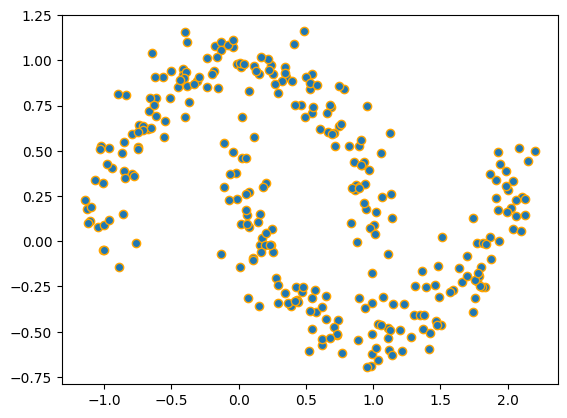

In [156]:
plt.scatter(X_moons[:, 0], X_moons[:, 1],edgecolor='orange')

### <font color="#bd33a4"> After Apply K-Means on Dataset3

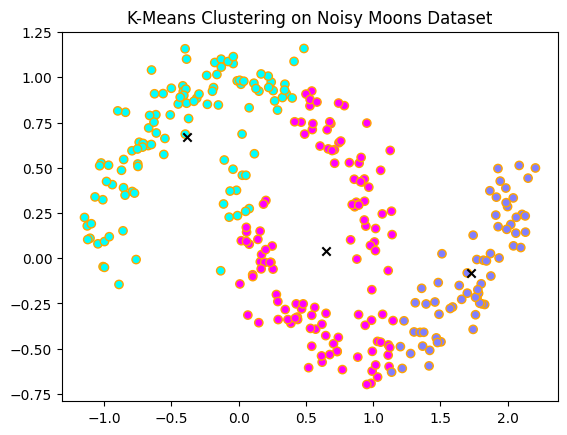

In [157]:
kmeans_moons = KMeans(n_clusters=3, random_state=random_state)
labels_moons = kmeans_moons.fit(X_moons)

# Plot
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=labels_moons,edgecolor='orange',cmap = "cool" )
plt.scatter(kmeans_moons.centroids[:, 0], kmeans_moons.centroids[:, 1], c='black', marker='x')
plt.title("K-Means Clustering on Noisy Moons Dataset")
plt.show()


In [158]:
f1_moons = f1_score(Y_moons, labels_moons, average='weighted')
nmi_moons = normalized_mutual_info_score(Y_moons, labels_moons)
rand_index_moons = rand_score(Y_moons, labels_moons)


print("**** Measures values for Dataset3 on Kmeans ****\n")
print("F-measure: {:.5f}".format(f1_moons))
print("Normalized Mutual Information (NMI): {:.5f}".format(nmi_moons))
print("Rand Index: {:.5f}".format(rand_index_moons))

**** Measures values for Dataset3 on Kmeans ****

F-measure: 0.67960
Normalized Mutual Information (NMI): 0.31256
Rand Index: 0.62916


### <font color="#bd33a4"> After Apply DBSCAN on Dataset3

In [159]:
#Implementing the DBSCAN model with dataset 3 and predicting labels
DB2=DBSCAN(X_moons,0.21,9)
Data_State2,corePoint2,borderPoint2=DB2.fit()
DBLabel2=DB2.predict(Data_State2,corePoint2,borderPoint2)

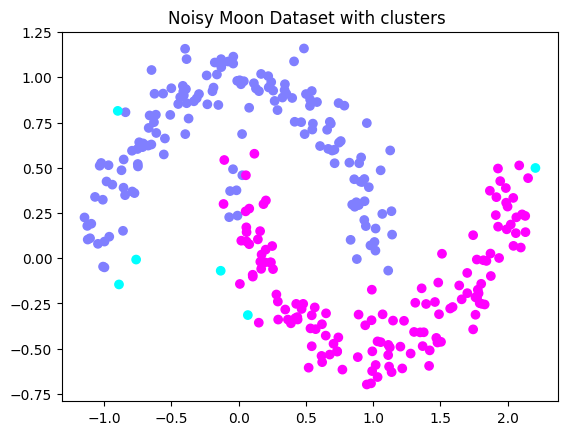

In [160]:
#the dataset 2 after DBSCAN model
plt.scatter(X_moons[:,0], X_moons[:,1], c=DBLabel2, cmap='cool')
plt.title('Noisy Moon Dataset with clusters ')
plt.show()

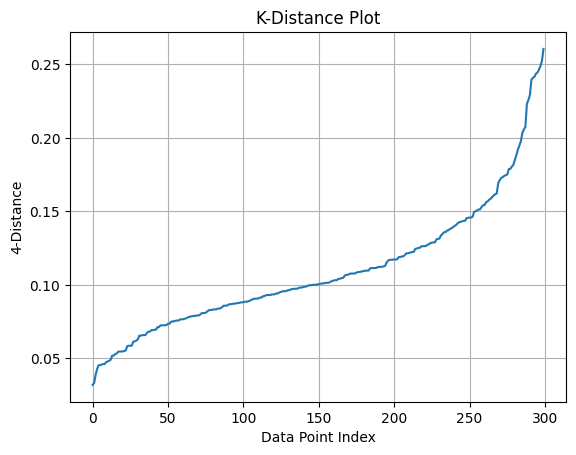

In [161]:
k = 4  # Set the value of k for the k-distance plot
neigh = NearestNeighbors(n_neighbors=k+1)
neigh.fit(X_moons)
distances, _ = neigh.kneighbors(X_moons)
k_distances = np.sort(distances[:, k], axis=0)

sorted_distances = np.sort(k_distances, axis=0)

plt.plot(np.arange(len(X_moons)), sorted_distances)
plt.xlabel("Data Point Index")
plt.ylabel(f"{k}-Distance")
plt.title("K-Distance Plot")
plt.grid(True)
plt.show()

In [162]:
#Implementing the DBSCAN model after determining the epsilon value
DB2=DBSCAN(X_moons,0.21,9)
Data_State2,corePoint2,borderPoint2=DB2.fit()
DBLabel2=DB2.predict(Data_State2,corePoint2,borderPoint2)

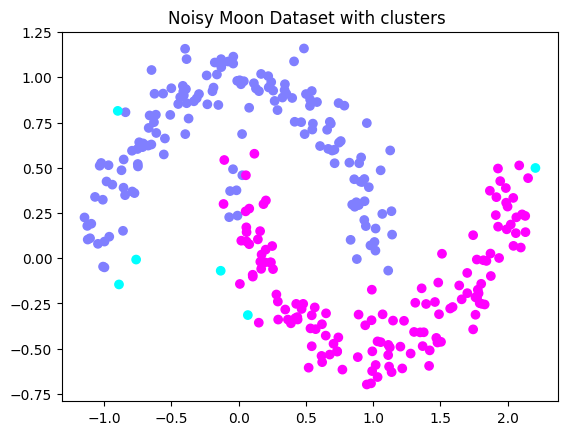

In [163]:
#demonstrating the DBSCAN model after determining the epsilon value
plt.scatter(X_moons[:,0], X_moons[:,1], c=DBLabel2, cmap='cool')
plt.title('Noisy Moon Dataset with clusters ')
plt.show()

In [164]:
f_measure3 = f1_score(Y_moons, DBLabel2, average='weighted')
nmi3 = normalized_mutual_info_score(Y_moons, DBLabel2)
rand_index3 = rand_score(Y_moons, DBLabel2)

print("**** Measures values for Dataset3 on DBSCAN ****\n")
print("F-measure: {:.5f}".format(f_measure3))
print("Normalized Mutual Information (NMI): {:.5f}".format(nmi3))
print("Rand Index: {:.5f}".format(rand_index3))

**** Measures values for Dataset3 on DBSCAN ****

F-measure: 0.96295
Normalized Mutual Information (NMI): 0.76848
Rand Index: 0.92912


 ### <font color="#bd33a4">  Summarize the measures values on Dataset3

In [165]:
data = {
    "Dataset": ["Moons", "Moons"],
    "Algorithm":["Kmean","DBSCAN"],
    "F1 Score": [f1_moons, f_measure3],
    "NMI": [nmi_moons,nmi3],
    "Rand Index": [rand_index_moons,rand_index3]
}

df_metrics = pd.DataFrame(data)
df_metrics

,Dataset,Algorithm,F1 Score,NMI,Rand Index
0,Moons,Kmean,0.679601,0.312556,0.629164
1,Moons,DBSCAN,0.962948,0.768485,0.929119


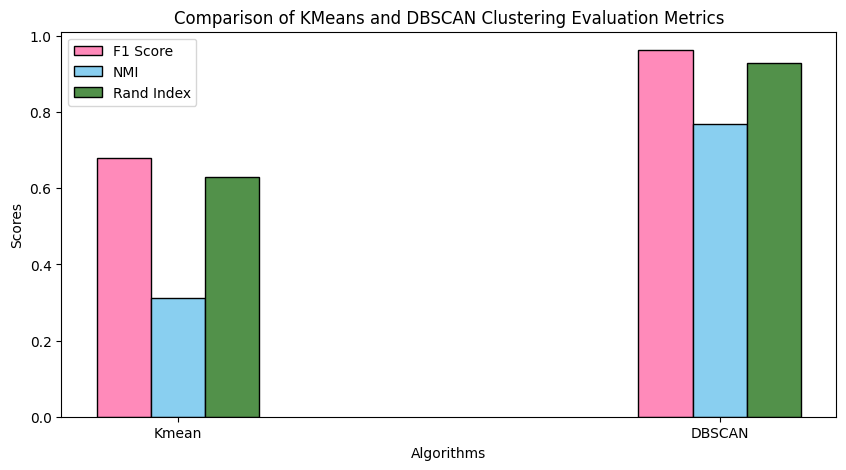

In [166]:
plt.figure(figsize=(10, 5))

metrics = df_metrics['Algorithm']
f1score = df_metrics["F1 Score"]
randscore = df_metrics["NMI"]
normalized_mutual = df_metrics["Rand Index"]

bar_width = 0.1
index = np.arange(len(metrics))

plt.bar(index - bar_width, f1score, bar_width, label='F1 Score', color="#FF8ABA", edgecolor='black')
plt.bar(index, randscore, bar_width, label='NMI', color="#89CFF0", edgecolor='black')
plt.bar(index + bar_width, normalized_mutual, bar_width, label='Rand Index', color="#52914A", edgecolor='black')

plt.xlabel("Algorithms")
plt.ylabel("Scores")
plt.title("Comparison of KMeans and DBSCAN Clustering Evaluation Metrics")
plt.xticks(index, metrics)
plt.legend()
plt.show()

### <font color="#bd33a4"> Dataset4: noisy circles dataset

In [167]:
X_circles, Y_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05, random_state=random_state)

### <font color="#bd33a4"> Before Apply K-Means and DBSCAN on Dataset4

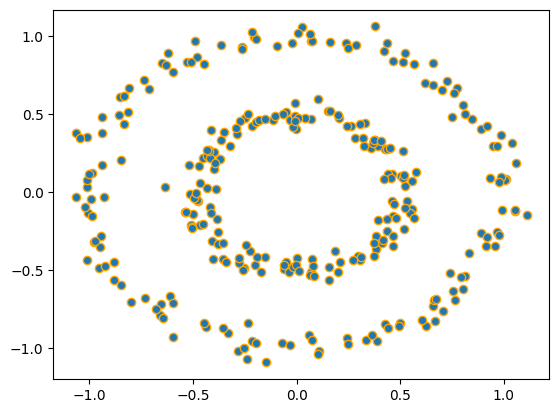

In [168]:
plt.scatter(X_circles[:, 0], X_circles[:, 1],edgecolor='orange')

### <font color="#bd33a4"> After Apply K-Means on Dataset4

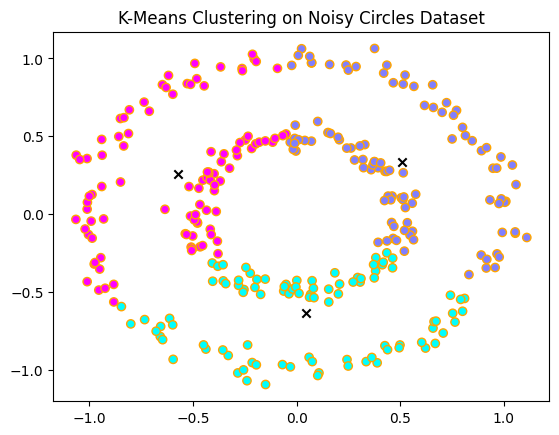

In [169]:
kmeans_circles = KMeans(n_clusters=3, random_state=random_state)
labels_circles = kmeans_circles.fit(X_circles)

# Plot
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=labels_circles, edgecolor='orange',cmap = "cool" )
plt.scatter(kmeans_circles.centroids[:, 0], kmeans_circles.centroids[:, 1], c='black', marker='x')
plt.title("K-Means Clustering on Noisy Circles Dataset")
plt.show()

In [170]:
f1_circles = f1_score(Y_circles, labels_circles, average='weighted')
nmi_circles = normalized_mutual_info_score(Y_circles, labels_circles)
rand_index_circles = rand_score(Y_circles, labels_circles)

print("**** Measures values for Dataset4 on Kmeans ****\n")
print("F-measure: {:.5f}".format(f1_circles))
print("Normalized Mutual Information (NMI): {:.5f}".format(nmi_circles))
print("Rand Index: {:.5f}".format(rand_index_circles))

**** Measures values for Dataset4 on Kmeans ****

F-measure: 0.40785
Normalized Mutual Information (NMI): 0.00015
Rand Index: 0.49842


### <font color="#bd33a4"> After Apply DBSCAN on Dataset4

In [171]:
#Implementing the DBSCAN model with dataset 4 and predicting labels
DB4=DBSCAN(X_circles,0.2,4)
Data_State4,corePoint4,borderPoint4=DB4.fit()
DBLabel4=DB4.predict(Data_State4,corePoint4,borderPoint4)

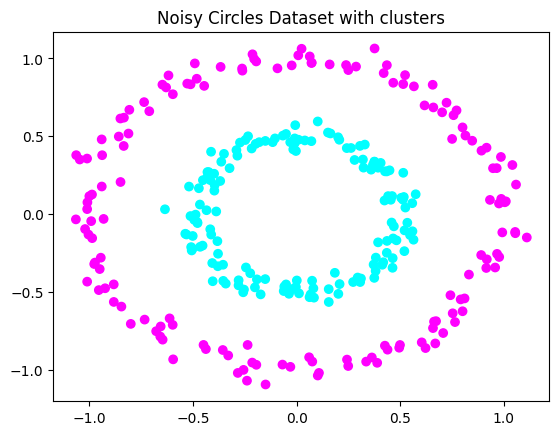

In [172]:
#the dataset 4 after DBSCAN model
plt.scatter(X_circles[:,0], X_circles[:,1], c=DBLabel4, cmap='cool')
plt.title('Noisy Circles Dataset with clusters')
plt.show()

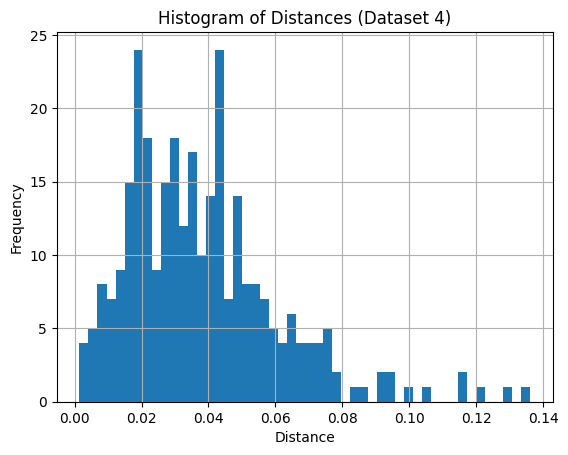

In [173]:
# Calculate distances
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(X_circles)
distances, _ = neigh.kneighbors(X_circles)
distances = np.sort(distances[:, 1], axis=0)

# Plot histogram of distances
plt.hist(distances, bins=50)
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Histogram of Distances (Dataset 4)")
plt.grid(True)

In [174]:
#Implementing the DBSCAN model with dataset after determining the epsilon value
DB4=DBSCAN(X_circles,0.2,4)
Data_State4,corePoint4,borderPoint4=DB4.fit()
DBLabel4=DB4.predict(Data_State4,corePoint4,borderPoint4)

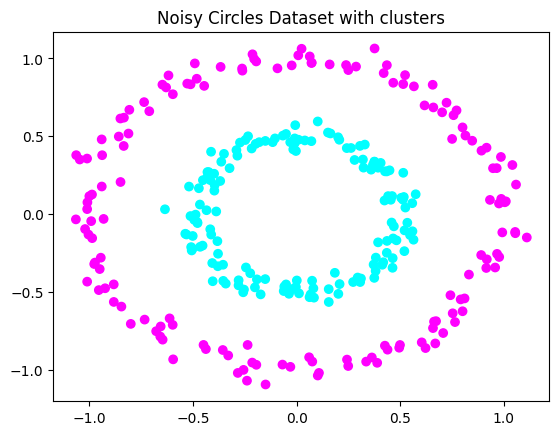

In [175]:
#Visualize the clusters
plt.scatter(X_circles[:,0], X_circles[:,1], c=DBLabel4, cmap='cool')
plt.title('Noisy Circles Dataset with clusters')
plt.show()

In [176]:
f_measure4 = f1_score(Y_circles, DBLabel4, average='weighted')
nmi4 = normalized_mutual_info_score(Y_circles, DBLabel4)
rand_index4 = rand_score(Y_circles, DBLabel4)

print("**** Measures values for Dataset4 on DBSCAN ****\n")
print("F-measure: {:.5f}".format(f_measure4))
print("Normalized Mutual Information (NMI): {:.5f}".format(nmi4))
print("Rand Index: {:.5f}".format(rand_index4))

**** Measures values for Dataset4 on DBSCAN ****

F-measure: 0.00000
Normalized Mutual Information (NMI): 1.00000
Rand Index: 1.00000


 ### <font color="#bd33a4">  Summarize the measures values on Dataset4

In [177]:
data = {
    "Dataset": ["Circles", "Circles"],
    "Algorithm":["Kmean","DBSCAN"],
    "F1 Score": [f1_circles,f_measure4],
    "NMI": [nmi_circles,nmi4],
    "Rand Index": [rand_index_circles,rand_index4]
}

df_metrics = pd.DataFrame(data)
df_metrics

,Dataset,Algorithm,F1 Score,NMI,Rand Index
0,Circles,Kmean,0.407848,0.000149,0.498417
1,Circles,DBSCAN,0.000000,1.000000,1.000000


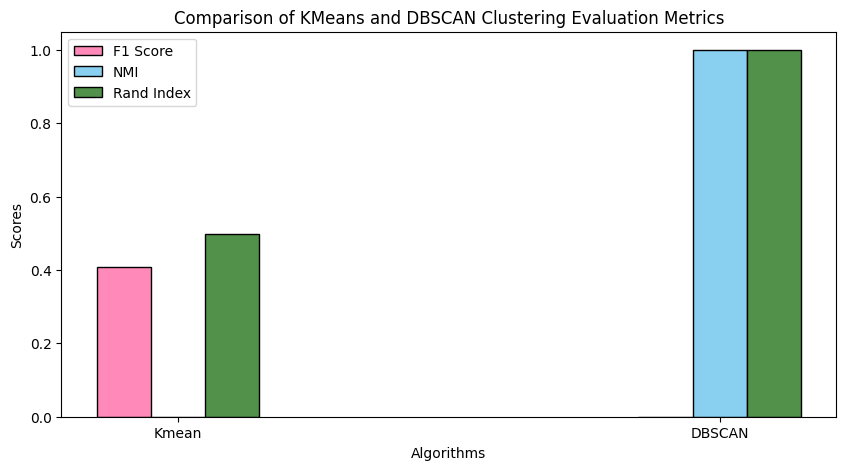

In [178]:
plt.figure(figsize=(10, 5))

metrics = df_metrics['Algorithm']
f1score = df_metrics["F1 Score"]
randscore = df_metrics["NMI"]
normalized_mutual = df_metrics["Rand Index"]

bar_width = 0.1
index = np.arange(len(metrics))

plt.bar(index - bar_width, f1score, bar_width, label='F1 Score', color="#FF8ABA", edgecolor='black')
plt.bar(index, randscore, bar_width, label='NMI', color="#89CFF0", edgecolor='black')
plt.bar(index + bar_width, normalized_mutual, bar_width, label='Rand Index', color="#52914A", edgecolor='black')

plt.xlabel("Algorithms")
plt.ylabel("Scores")
plt.title("Comparison of KMeans and DBSCAN Clustering Evaluation Metrics")
plt.xticks(index, metrics)
plt.legend()
plt.show()

 ### <font color="#bd33a4">  Summarize all the measures values

In [179]:
data = {
    "Dataset": ["Blobs", "Blobs", "Anisotropic", "Anisotropic","Moons", "Moons", "Circles", "Circles"],
    "Algorithm":["Kmean","DBSCAN","Kmean","DBSCAN","Kmean","DBSCAN","Kmean","DBSCAN"],
    "F1 Score": [f1_blob, f_measure,f1_aniso, f_measure2,f1_moons,f_measure3, f1_circles,f_measure4],
    "NMI": [nmi_blob,nmi, nmi_aniso,nmi2, nmi_moons,nmi3, nmi_circles,nmi4],
    "Rand Index": [rand_index_blob,rand_index, rand_index_aniso,rand_index2, rand_index_moons,rand_index3, rand_index_circles,rand_index4]
}

df_metrics = pd.DataFrame(data)
df_metrics

,Dataset,Algorithm,F1 Score,NMI,Rand Index
0,Blobs,Kmean,0.000000,1.000000,1.000000
1,Blobs,DBSCAN,0.329966,0.934929,0.982252
2,Anisotropic,Kmean,0.331675,0.982993,0.995563
3,Anisotropic,DBSCAN,0.328257,0.942195,0.984482
4,Moons,Kmean,0.679601,0.312556,0.629164
5,Moons,DBSCAN,0.962948,0.768485,0.929119
6,Circles,Kmean,0.407848,0.000149,0.498417
7,Circles,DBSCAN,0.000000,1.000000,1.000000


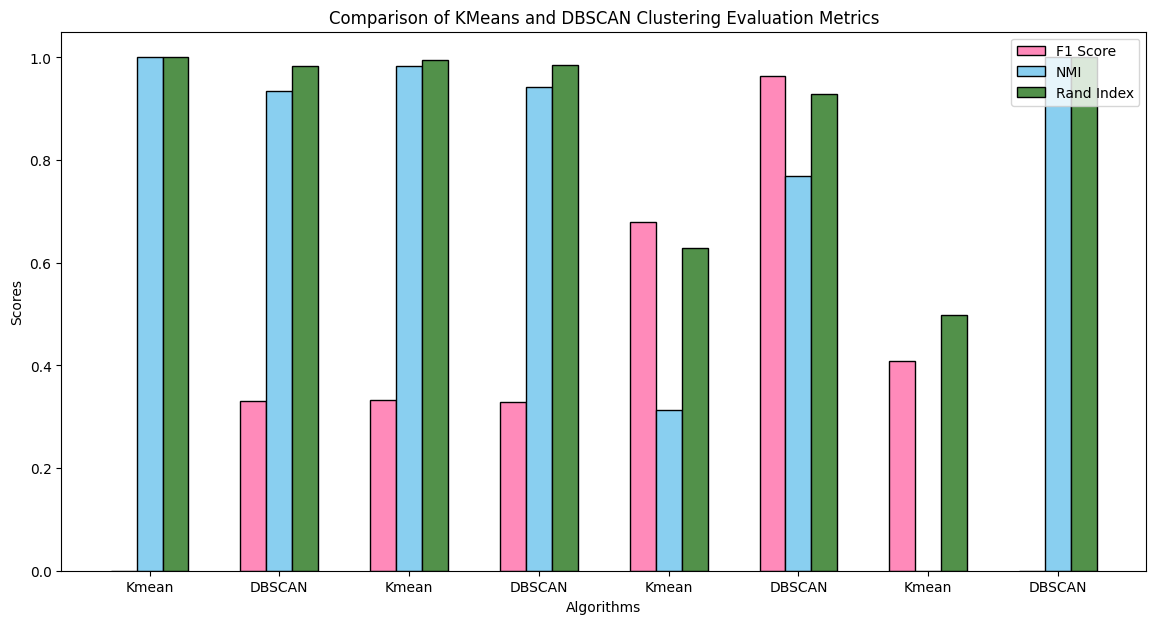

In [180]:

plt.figure(figsize=(14, 7))

metrics = df_metrics['Algorithm']
f1score = df_metrics["F1 Score"]
randscore = df_metrics["NMI"]
normalized_mutual = df_metrics["Rand Index"]

bar_width = 0.2
index = np.arange(len(metrics))

plt.bar(index - bar_width, f1score, bar_width, label='F1 Score', color="#FF8ABA", edgecolor='black')
plt.bar(index, randscore, bar_width, label='NMI', color="#89CFF0", edgecolor='black')
plt.bar(index + bar_width, normalized_mutual, bar_width, label='Rand Index', color="#52914A", edgecolor='black')

plt.xlabel("Algorithms")
plt.ylabel("Scores")
plt.title("Comparison of KMeans and DBSCAN Clustering Evaluation Metrics")
plt.xticks(index, metrics)
plt.legend()
plt.show()
